### Import necessary libraries

In [1]:
import pandas as pd
import geopandas as gpd
import os

This file was downloaded from https://www.ers.usda.gov/data-products/rural-urban-continuum-codes this link, which contains
rural urban classification for each county.

## Read downloaded file

In [2]:
df = pd.read_csv(r"F:\onedrive\OneDrive - University of Central Florida\Rural_urban\Ruralurbancontinuumcodes2023.csv", encoding='ISO-8859-1')

In [3]:
## filter FL to only take state of Florida
df = df[df['State'] == 'FL']

In [4]:
# Column that represents urban-rural codes
df = df[df['Attribute'] == 'RUCC_2023']

In [5]:
df['Value'] = df['Value'].apply(pd.to_numeric)

In [6]:
# As suggested by litarature we are considering 1-3 as metro and rest as non-metro
df['Urban_class'] = df['Value'].apply(lambda x: 'metro' if x <=3 else 'non-metro')

In [7]:
## Changing column name so that it is aligned with florida county shapefile
df.rename(columns ={'County_Name': 'NAMELSAD'}, inplace = True)

In [8]:
df.head()

,FIPS,State,NAMELSAD,Attribute,Value,Urban_class
967,12001,FL,Alachua County,RUCC_2023,2,metro
970,12003,FL,Baker County,RUCC_2023,1,metro
973,12005,FL,Bay County,RUCC_2023,3,metro
976,12007,FL,Bradford County,RUCC_2023,6,non-metro
979,12009,FL,Brevard County,RUCC_2023,2,metro


In [9]:
df['Value'].value_counts()

2    22
1    16
8    10
3     7
6     6
4     5
9     1
Name: Value, dtype: int64

<Axes: >

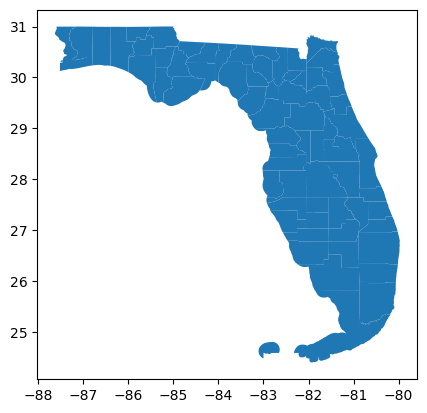

In [10]:
## read florida county shapefile
county_shp = gpd.read_file(r"F:\onedrive\OneDrive - University of Central Florida\Florida_shp\Florida_county.shp")
county_shp.plot()

In [11]:
county_shp =county_shp.to_crs(epsg = 4326)
county_shp['centroid'] = county_shp.geometry.centroid
county_shp['lon'] = county_shp['centroid'].x
county_shp['lat'] = county_shp['centroid'].y

C:\Users\mo314794\AppData\Local\Temp\ipykernel_18220\3336002668.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_shp['centroid'] = county_shp.geometry.centroid


In [21]:
county_shp =county_shp.to_crs(epsg = 4326)
county_shp['area'] = county_shp.geometry.area/1e6

C:\Users\mo314794\AppData\Local\Temp\ipykernel_18220\4137344887.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_shp['area'] = county_shp.geometry.area/1e6


In [22]:
combined_df =gpd.GeoDataFrame(pd.merge(df, county_shp, on = 'NAMELSAD', how = 'inner'), crs = county_shp.crs)

In [23]:
combined_df.set_geometry('geometry', inplace =True)

In [24]:
combined_df.columns

Index(['FIPS', 'State', 'NAMELSAD', 'Attribute', 'Value', 'Urban_class',
       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'LSAD', 'CLASSFP',
       'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry', 'centroid', 'lon', 'lat', 'area'],
      dtype='object')

In [25]:
df1 = pd.read_csv(r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\regional_model\filename_mapping.csv")
df1.rename(columns = {'Original Filename': 'NAME', 'New Filename': 'county_code'}, inplace = True)

In [26]:
combined1 = pd.merge(combined_df, df1, on = 'NAME', how = 'inner')

In [27]:
combined1[['NAME', 'county_code', 'Value', 'lat', 'lon', 'area']].to_csv(r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\attribute.csv", index = False)

<Figure size 1200x800 with 0 Axes>

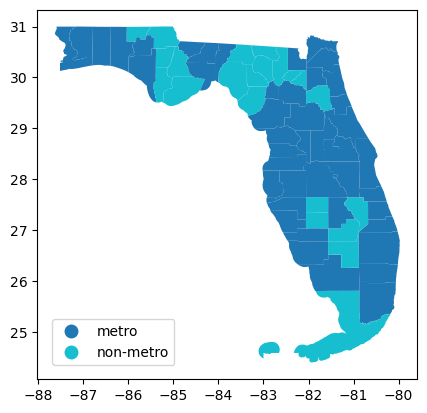

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

combined_df.plot(
    column='Urban_class',
    legend=True,
    legend_kwds={
        'loc': 'lower left',  # Position the legend at the bottom-left
        'bbox_to_anchor': (0.02, 0.02),  # Adjust the exact position
        'fontsize': 10,  # Optional: Adjust font size
        'frameon': True   # Optional: Add a frame around the legend
    }
)

plt.show()


### without basemap

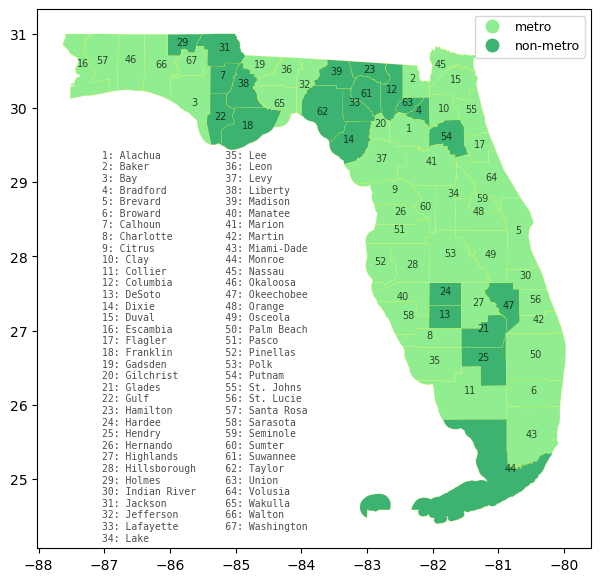

In [131]:
import matplotlib.pyplot as plt
import math
import matplotlib.colors as mcolors
# Add a new column 'Label' with numbers starting from 1
combined_df['Label'] = range(1, len(combined_df) + 1)

# Adjust figure size to add space for the legend on the right
fig, ax = plt.subplots(figsize=(11, 7))  # Increased width for better legend placement
custom_cmap = mcolors.ListedColormap(["#90EE90", "#3CB371"])
# Plot the dataframe with the Urban_class legend in the upper right
combined_df.plot(
    column='Urban_class',
    ax=ax,
    edgecolor = 'yellow',
    linewidth = 0.1,
    legend=True,
    cmap = custom_cmap,
    legend_kwds={
        'loc': 'upper right',  # Move legend to the upper right
        'fontsize': 9,
        'frameon': True
    }
)
# Add numeric labels for counties at representative points
for idx, row in combined_df.iterrows():
    point = row.geometry.representative_point()  # Get a better placement point
    plt.text(point.x, point.y, 
             str(row['Label']), fontsize=7, ha='center', color='black', alpha =0.7)

# Create a multi-column legend for numbers and names
num_items = len(combined_df)
num_columns = 2  # Adjust based on how many columns you want
rows_per_column = math.ceil(num_items / num_columns)

legend_text = ""
for i in range(rows_per_column):
    col1 = f"{combined_df.iloc[i]['Label']}: {combined_df.iloc[i]['NAME']}" if i < num_items else ""
    col2 = f"{combined_df.iloc[i + rows_per_column]['Label']}: {combined_df.iloc[i + rows_per_column]['NAME']}" if i + rows_per_column < num_items else ""
    legend_text += f"{col1:<20} {col2:<20}\n"

# Add the multi-column legend as a separate text box on the right
plt.gcf().text(0.32, 0.39, legend_text, fontsize=7, verticalalignment='center', alpha=0.7,  family='monospace')

# Show the plot
plt.show()


### With basemap

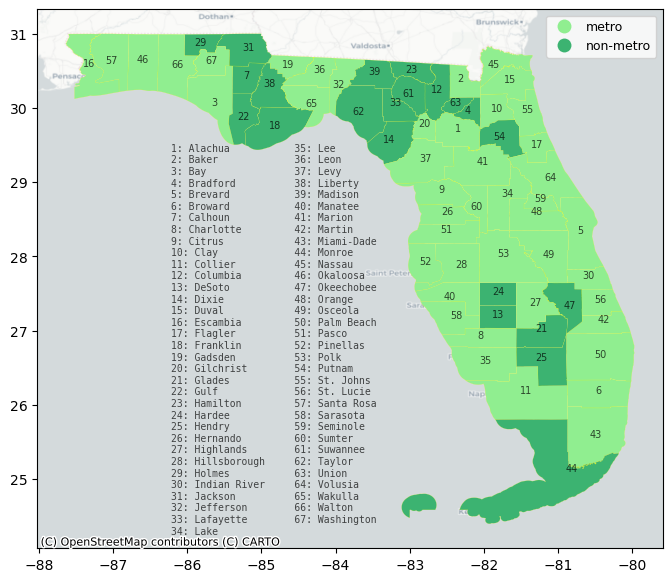

In [138]:
import matplotlib.pyplot as plt
import math
import matplotlib.colors as mcolors
import contextily as ctx  # For adding basemap

# Add a new column 'Label' with numbers starting from 1
combined_df['Label'] = range(1, len(combined_df) + 1)

# Adjust figure size to add space for the legend on the right
fig, ax = plt.subplots(figsize=(11, 7))  # Increased width for better legend placement
custom_cmap = mcolors.ListedColormap(["#90EE90", "#3CB371"])

# Plot the dataframe with the Urban_class legend in the upper right
combined_df.plot(
    column='Urban_class',
    ax=ax,
    edgecolor='yellow',
    linewidth=0.1,
    legend=True,
    cmap=custom_cmap,
    legend_kwds={
        'loc': 'upper right',  # Move legend to the upper right
        'fontsize': 9,
        'frameon': True
    }
)

# Add numeric labels for counties at representative points
for idx, row in combined_df.iterrows():
    point = row.geometry.representative_point()  # Get a better placement point
    plt.text(point.x, point.y, 
             str(row['Label']), fontsize=7, ha='center', color='black', alpha=0.7)

# Create a multi-column legend for numbers and names
num_items = len(combined_df)
num_columns = 2  # Adjust based on how many columns you want
rows_per_column = math.ceil(num_items / num_columns)

legend_text = ""
for i in range(rows_per_column):
    col1 = f"{combined_df.iloc[i]['Label']}: {combined_df.iloc[i]['NAME']}" if i < num_items else ""
    col2 = f"{combined_df.iloc[i + rows_per_column]['Label']}: {combined_df.iloc[i + rows_per_column]['NAME']}" if i + rows_per_column < num_items else ""
    legend_text += f"{col1:<20} {col2:<20}\n"

# Add the multi-column legend as a separate text box on the right
plt.gcf().text(0.35, 0.40, legend_text, fontsize=7, verticalalignment='center', alpha=0.7, family='monospace')

# Add basemap (OpenStreetMap - Mapnik)
#ctx.add_basemap(ax, crs=combined_df.crs.to_string(), source=ctx.providers.OpenStreetMap.BlackAndWhite)
ctx.add_basemap(ax, crs=combined_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# Show the plot
plt.show()


In [ ]:
## From SAIDI value we can also find how saidi values vary from rural to urban areas

In [35]:
df['NAME'] = df['NAMELSAD'].str.split().str[:-1].str.join(' ')

In [39]:
rural_df = df[df['Urban_class'] == 'non-metro']

In [41]:
urban_df = df[df['Urban_class'] == 'metro']

In [42]:
outage_df = pd.read_csv(r"F:\onedrive\OneDrive - University of Central Florida\compound_paper_data\saidi_df1.csv")

In [43]:
outage_df.columns

Index(['NAME', 'weather_outage_count', 'weather_percentage',
       'total_outage_count', 'Avg_Weather_SAIDI', 'Avg_NonWeather_SAIDI',
       'Avg_TC_SAIDI', 'Avg_NonTC_SAIDI'],
      dtype='object')

In [44]:
urban_merged = pd.merge(urban_df, outage_df,  on = 'NAME', how = 'inner')

In [45]:
urban_merged = pd.merge(urban_df, outage_df,  on = 'NAME', how = 'inner')

In [46]:
rural_merged = pd.merge(rural_df, outage_df,  on = 'NAME', how = 'inner')

In [47]:
print(f" Counts of total events for metro: {round(urban_merged['total_outage_count'].mean(), 2)}")
print(f" Counts of total events for nonmetro: {round(rural_merged['total_outage_count'].mean(), 2)}\n")

print(f" Counts of weather outage events for metro: {round(urban_merged['weather_outage_count'].mean(), 2)}")
print(f" Counts of weather outage events for nonmetro: {round(rural_merged['weather_outage_count'].mean(), 2)}\n")

print(f" Percentage of weather events for metro: {round(urban_merged['weather_percentage'].mean(), 2)}")
print(f" Percentage of weather events for nonmetro: {round(rural_merged['weather_percentage'].mean(), 2)}\n")

print(f" Average weather SAIDI for metro: {round(urban_merged['Avg_Weather_SAIDI'].mean(), 2)}")
print(f" Average Weather SAIDI for nonmetro: {round(rural_merged['Avg_Weather_SAIDI'].mean(), 2)}\n")

print(f" Average nonweather SAIDI for metro: {round(urban_merged['Avg_NonWeather_SAIDI'].mean(), 2)}")
print(f" Average nonWeather SAIDI for nonmetro: {round(rural_merged['Avg_NonWeather_SAIDI'].mean(), 2)}\n")

print(f" Average TC SAIDI for metro: {round(urban_merged['Avg_TC_SAIDI'].mean(), 2)}")
print(f" Average TC SAIDI for nonmetro: {round(rural_merged['Avg_TC_SAIDI'].mean(), 2)}\n")

print(f" Average nonTC SAIDI for metro: {round(urban_merged['Avg_NonTC_SAIDI'].mean(), 2)}")
print(f" Average nonTC SAIDI for nonmetro: {round(rural_merged['Avg_NonTC_SAIDI'].mean(), 2)}\n")


 Counts of total events for metro: 959.18
 Counts of total events for nonmetro: 305.86

 Counts of weather outage events for metro: 472.93
 Counts of weather outage events for nonmetro: 173.14

 Percentage of weather events for metro: 50.97
 Percentage of weather events for nonmetro: 58.4

 Average weather SAIDI for metro: 2328.25
 Average Weather SAIDI for nonmetro: 2473.95

 Average nonweather SAIDI for metro: 413.54
 Average nonWeather SAIDI for nonmetro: 491.39

 Average TC SAIDI for metro: 2230.8
 Average TC SAIDI for nonmetro: 2522.56

 Average nonTC SAIDI for metro: 577.41
 Average nonTC SAIDI for nonmetro: 562.0



In [48]:
print(f" Counts of total events for metro: {round(urban_merged['total_outage_count'].mean(), 2)}")
print(f" Counts of total events for nonmetro: {round(rural_merged['total_outage_count'].mean(), 2)}\n")

print(f" Counts of weather outage events for metro: {round(urban_merged['weather_outage_count'].mean(), 2)}")
print(f" Counts of weather outage events for nonmetro: {round(rural_merged['weather_outage_count'].mean(), 2)}\n")

print(f" Percentage of weather events for metro: {round(urban_merged['weather_percentage'].mean(), 2)}")
print(f" Percentage of weather events for nonmetro: {round(rural_merged['weather_percentage'].mean(), 2)}\n")

print(f" Average weather SAIDI for metro: {round(urban_merged['Avg_Weather_SAIDI'].mean(), 2)}")
print(f" Average Weather SAIDI for nonmetro: {round(rural_merged['Avg_Weather_SAIDI'].mean(), 2)}\n")

print(f" Average nonweather SAIDI for metro: {round(urban_merged['Avg_NonWeather_SAIDI'].mean(), 2)}")
print(f" Average nonWeather SAIDI for nonmetro: {round(rural_merged['Avg_NonWeather_SAIDI'].mean(), 2)}\n")

print(f" Average TC SAIDI for metro: {round(urban_merged['Avg_TC_SAIDI'].mean(), 2)}")
print(f" Average TC SAIDI for nonmetro: {round(rural_merged['Avg_TC_SAIDI'].mean(), 2)}\n")

print(f" Average nonTC SAIDI for metro: {round(urban_merged['Avg_NonTC_SAIDI'].mean(), 2)}")
print(f" Average nonTC SAIDI for nonmetro: {round(rural_merged['Avg_NonTC_SAIDI'].mean(), 2)}\n")

 Counts of total events for metro: 959.18
 Counts of total events for nonmetro: 305.86

 Counts of weather outage events for metro: 472.93
 Counts of weather outage events for nonmetro: 173.14

 Percentage of weather events for metro: 50.97
 Percentage of weather events for nonmetro: 58.4

 Average weather SAIDI for metro: 2328.25
 Average Weather SAIDI for nonmetro: 2473.95

 Average nonweather SAIDI for metro: 413.54
 Average nonWeather SAIDI for nonmetro: 491.39

 Average TC SAIDI for metro: 2230.8
 Average TC SAIDI for nonmetro: 2522.56

 Average nonTC SAIDI for metro: 577.41
 Average nonTC SAIDI for nonmetro: 562.0



In [49]:
urban_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 967 to 1165
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   FIPS         45 non-null     int64 
 1   State        45 non-null     object
 2   NAMELSAD     45 non-null     object
 3   Attribute    45 non-null     object
 4   Value        45 non-null     int64 
 5   Urban_class  45 non-null     object
 6   NAME         45 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.8+ KB
